In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time
import pandas as pd


CV2_INTERPOLATION_METHODS = [
    cv2.INTER_NEAREST,
    cv2.INTER_LINEAR,
    cv2.INTER_CUBIC,
]

# RGB vs Grayscale (CV2)

In [2]:
def resize_image(img, scale_factor, cv2_method=cv2.INTER_CUBIC):
    assert cv2_method in CV2_INTERPOLATION_METHODS

    if not isinstance(img, np.ndarray):
        img = np.asarray(img, dtype=np.uint8)

    downscaled = cv2.resize(img, dsize=None, dst=0, fx=scale_factor, fy=scale_factor, interpolation=cv2_method)
    return downscaled

def time_resizing_cv2(img_list, scale_factor, n_times=50, cv2_method=cv2.INTER_CUBIC):
    time_array = [0] * n_times * len(img_list)
    for img_idx, img in enumerate(img_list):
        for i in range(n_times):
            start = time()
            resize_image(img, scale_factor, cv2_method=cv2_method)
            end = time() - start
            time_array[i + img_idx * n_times] = end
        mean = np.array(time_array).mean()
        std = np.array(time_array).std()
    return mean, std

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

parrot_img = Image.open("parrot.png")
lenna_img = Image.open("lenna.png")
boats_img = Image.open("boats.png")
canyon_img = Image.open("canyon.jpg")
fox_img = Image.open("fox.jpg")
car_img = Image.open("car.jpg")

IMAGE_LIST = [parrot_img, lenna_img, boats_img, canyon_img, fox_img, car_img]
METHODS = [
    (cv2.INTER_NEAREST, "CV2_NEAREST"), 
    (cv2.INTER_LINEAR, "CV2_BILINEAR"),
    (cv2.INTER_CUBIC, "CV2_CUBIC"),
]

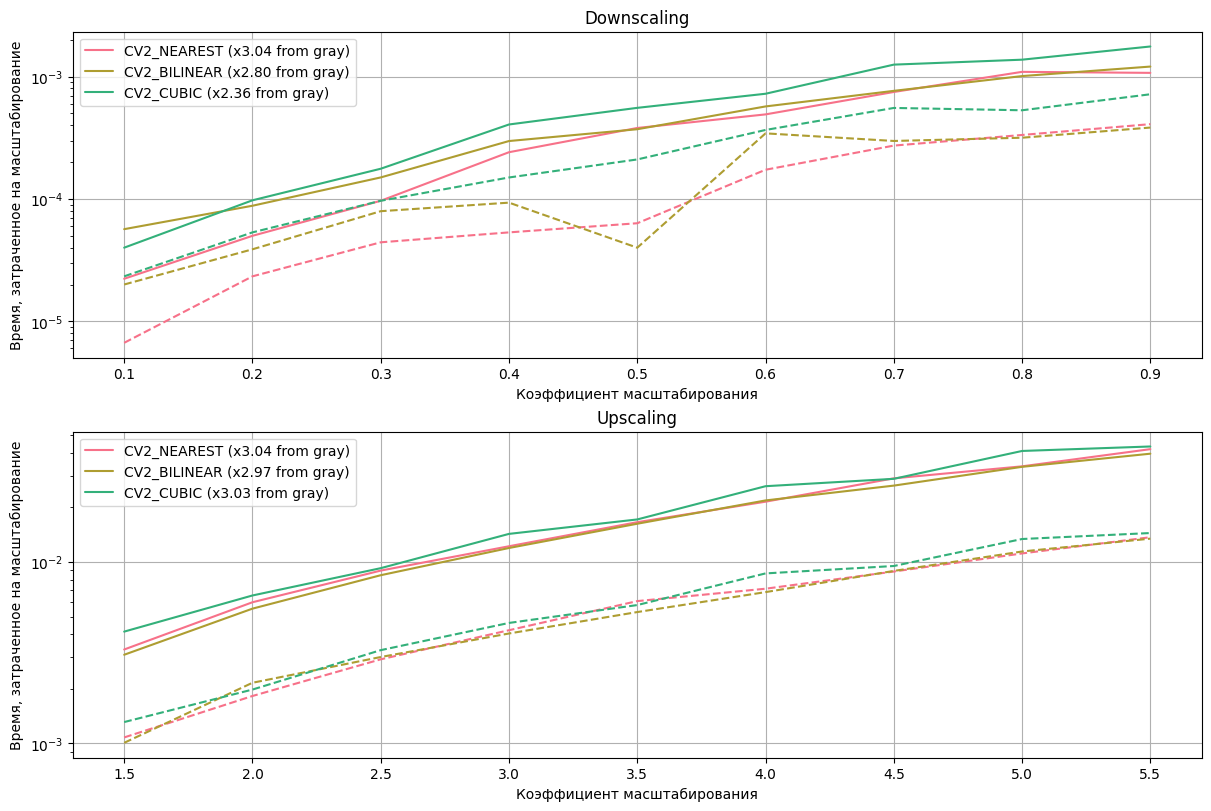

In [34]:
SCALE_FACTORS = np.linspace(0.1, 0.9, 9)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), layout="constrained")
ax = ax.ravel()
clrs = sns.color_palette("husl", 5)

for idx, method_name in enumerate(METHODS):
    method, name = method_name
    cmap_timings = {'L': 0, 'RGB': 0}
    for cmap in ["L", "RGB"]:
        image_list = [np.array(img.convert(cmap)) for img in IMAGE_LIST]
        time_results = {}
        for scale_factor in SCALE_FACTORS:
            mean, std = time_resizing_cv2(image_list, scale_factor, n_times=50, cv2_method=method)
            time_results[scale_factor] = (mean, std)
        with sns.axes_style("darkgrid"):
            mean_timings = np.array([v[0] for v in time_results.values()])
            std_timings = np.array([v[1] for v in time_results.values()])
            cmap_timings[cmap] = mean_timings.mean()
            label = f"{name} (x{cmap_timings['RGB'] / cmap_timings['L']:.2f} from gray)" if cmap == "RGB" else ""
            ax[0].plot(SCALE_FACTORS, mean_timings, '--' if cmap=='L' else '-', label=label, color=clrs[idx])
            # ax.fill_between(SCALE_FACTORS, mean_timings-std_timings, mean_timings+std_timings, alpha=0.2, color=clrs[idx])

ax[0].grid()
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel("Коэффициент масштабирования")
ax[0].set_ylabel("Время, затраченное на масштабирование")
ax[0].set_title("Downscaling")

SCALE_FACTORS = np.arange(1.5, 1.5 + 0.5*9, 0.5)


for idx, method_name in enumerate(METHODS):
    method, name = method_name
    cmap_timings = {'L': 0, 'RGB': 0}
    for cmap in ["L", "RGB"]:
        image_list = [np.array(img.convert(cmap)) for img in IMAGE_LIST]
        time_results = {}
        for scale_factor in SCALE_FACTORS:
            mean, std = time_resizing_cv2(image_list, scale_factor, n_times=50, cv2_method=method)
            time_results[scale_factor] = (mean, std)
        with sns.axes_style("darkgrid"):
            mean_timings = np.array([v[0] for v in time_results.values()])
            std_timings = np.array([v[1] for v in time_results.values()])
            cmap_timings[cmap] = mean_timings.mean()
            label = f"{name} (x{cmap_timings['RGB'] / cmap_timings['L']:.2f} from gray)" if cmap == "RGB" else ""
            ax[1].plot(SCALE_FACTORS, mean_timings, '--' if cmap=='L' else '-', label=label, color=clrs[idx])
            # ax.fill_between(SCALE_FACTORS, mean_timings-std_timings, mean_timings+std_timings, alpha=0.2, color=clrs[idx])

ax[1].grid()
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel("Коэффициент масштабирования")
ax[1].set_ylabel("Время, затраченное на масштабирование")
ax[1].set_title("Upscaling")
plt.show()

# Time comparison (our vs cv2)

In [94]:
def our_nearest_resize(image, dsize):
    original_height, original_width = image.shape
    new_height, new_width = dsize

    original_height, original_width = image.shape
    new_image = np.zeros((new_height, new_width), dtype=image.dtype)

    x_scale = original_width / new_width
    y_scale = original_height / new_height

    x_coords, y_coords = np.meshgrid(np.arange(new_width), np.arange(new_height))

    original_x = np.minimum(np.floor(x_coords * x_scale).astype(int), original_width - 1)
    original_y = np.minimum(np.floor(y_coords * y_scale).astype(int), original_height - 1)

    new_image = image[original_y, original_x]

    return new_image

def our_bilinear_resize(img, dsize):
    def bilinear_interpolate_numpy(img, x, y):
        x1 = np.clip(x, 0, img.shape[1]-1)
        x2 = np.clip(x + 1, 0, img.shape[1]-1)
        y1 = np.clip(y, 0, img.shape[0]-1)
        y2 = np.clip(y + 1, 0, img.shape[0]-1)

        return (img[y1, x1].T * (x2 - x) * (y2 - y)).T + \
            (img[y2, x1].T * (x2 - x) * (y - y1)).T + \
            (img[y1, x2].T * (x - x1) * (y2 - y)).T + \
            (img[y2, x2].T * (x - x1) * (y - y1)).T
    ih, iw = img.shape[:2]
    downscale_factor = ih / dsize[0]
    if downscale_factor < 1:
        ih, iw = img.shape[:2]
        upscaled = np.asarray(Image.fromarray(img).resize(dsize[::-1]))
        return upscaled
    downscale_factor = int(downscale_factor)
    new_np_img = np.zeros((int(img.shape[0] // downscale_factor), int(img.shape[1] // downscale_factor)), dtype=np.uint8)
    x = np.array([int(downscale_factor // 2) + i*downscale_factor for i in range(new_np_img.shape[1])])
    y = np.array([int(downscale_factor // 2) + i*downscale_factor for i in range(new_np_img.shape[0])])


    for i in range(0, new_np_img.shape[0]):
        new_np_img[i, :] = bilinear_interpolate_numpy(img, x, np.array([y[i]] * new_np_img.shape[1]))
    
    return new_np_img

def out_bicubic_resize(img, dsize):
    ih, iw = img.shape[:2]
    downscale_factor = ih / dsize[0]
    if downscale_factor < 1:
        ih, iw = img.shape[:2]
        upscaled = np.asarray(Image.fromarray(img).resize(dsize[::-1]))
        return upscaled
    downscale_factor = int(downscale_factor)

    x = np.array([(i + 0.5) * (downscale_factor) - 0.5 for j in range(img.shape[0] // downscale_factor) for i in range(img.shape[1] // downscale_factor) ])
    y = np.array([(j + 0.5) * (downscale_factor) - 0.5 for j in range(img.shape[0] // downscale_factor) for i in range(img.shape[1] // downscale_factor) ])

    x1 = x.astype(np.int32)
    y1 = y.astype(np.int32)
    np_img2 = np.zeros(((img.shape[0] // downscale_factor)* (img.shape[1] // downscale_factor)))

    x2 = x[0] - x1[0]
    y2 = y[0] - y1[0]

    for n in range(-1, 3):
        for m in range(-1, 3):
            if np.all(x1 + n < 0)  |  np.all(x1 + n >= img.shape[0]) | np.all(y1 + m < 0)  | np.all(y1 + m >= img.shape[1]):
                continue
            x1 += n
            y1 += m 
            x1[x1 >= img.shape[1]] = img.shape[1] - 1
            y1[y1 >= img.shape[0]] = img.shape[0] - 1
            x1[x1 < 0] = 0
            y1[y1 < 0] = 0
            
            np_img1_1 = img[y1, x1]

            def  func_weight(x):
                a = -0.5
                p = np.abs(x)
                if -1 <= np.abs(x) <= 1:
                    return ((a + 2) * (p ** 3)) - ((a + 3) * (p ** 2)) + 1
                elif 1 < x < 2 or -2 < x < -1:
                    return ((a * (p ** 3)) - (5 * a  * (p ** 2)) + (8 * a * p) - 4 * a)
                return 0

            a = func_weight(x2 - n)
            b = func_weight(y2 - m)

            np_img2[:] += (np_img1_1 * a * b)
            
            x1 -= n
            y1 -= m
  
    np_img2 = np.clip(np_img2, 0, 255).reshape(img.shape[0] // downscale_factor, img.shape[1] // downscale_factor).astype(np.uint8)
    return np_img2

def wrap_cv2_resize(img, dsize, cv2_method):
    assert cv2_method in CV2_INTERPOLATION_METHODS
    if not isinstance(img, np.ndarray):
        img = np.asarray(img, dtype=np.uint8)

    resized = cv2.resize(img, dsize=dsize[::-1], dst=0, fx=0, fy=0, interpolation=cv2_method)
    return resized

In [70]:
from time import time_ns

parrot_img = np.array(Image.open("parrot.png").convert("L"))
lenna_img = np.array(Image.open("lenna.png").convert("L"))
boats_img = np.array(Image.open("boats.png").convert("L"))
canyon_img = np.array(Image.open("canyon.jpg").convert("L"))
fox_img = np.array(Image.open("fox.jpg").convert("L"))
car_img = np.array(Image.open("car.jpg").convert("L"))

IMAGE_LIST = [parrot_img, lenna_img, boats_img, canyon_img, fox_img, car_img]
METHODS = [
    ("CV2_NEAREST", cv2.INTER_NEAREST), 
    ("CV2_BILINEAR", cv2.INTER_LINEAR),
    ("CV2_CUBIC", cv2.INTER_CUBIC),
    ("OUR_NEAREST", our_nearest_resize),
    ("OUR_BILINEAR", our_bilinear_resize),
    ("OUR_BICUBIC", out_bicubic_resize)
]
DOWNSCALE_FACTORS = [2, 3, 4, 5]

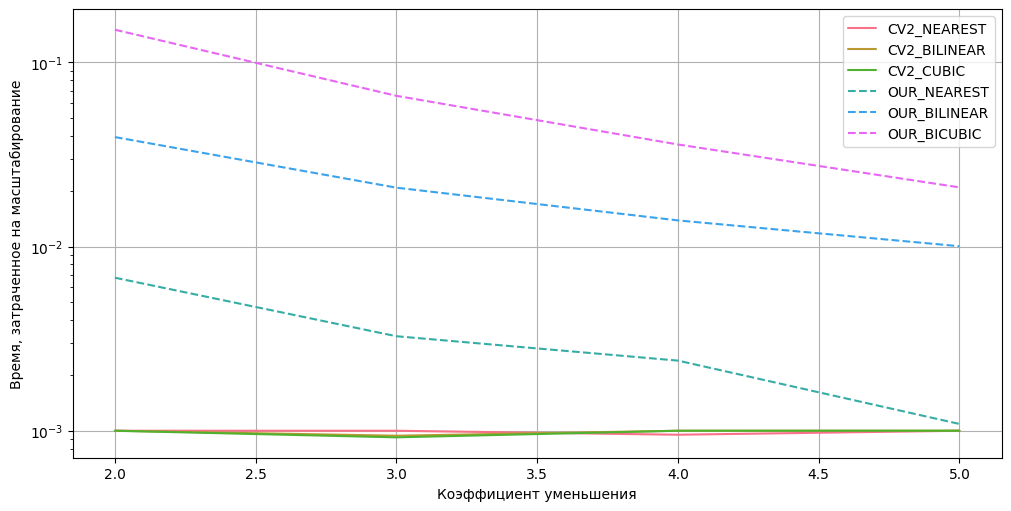

In [71]:
fig, ax = plt.subplots(figsize=(10, 5), layout="constrained")
clrs = sns.color_palette("husl", 6)

for idx, name_method in enumerate(METHODS):
    name, method = name_method
    time_results = {factor: [] for factor in DOWNSCALE_FACTORS}
    for downscale_factor in DOWNSCALE_FACTORS:
        timings = []
        for img in IMAGE_LIST:
            for _ in range(50):
                ih, iw = img.shape[:2]
                downscale_size = (ih // downscale_factor, iw // downscale_factor)
                downscale_size = tuple(map(int, downscale_size))
                start = time()
                if "CV2_" in name:
                    # print(img.shape, downscale_size)
                    wrap_cv2_resize(img, downscale_size, method)
                else:
                    method(img, downscale_size)
                total = time() - start
                if total > 0:
                    timings.append(total)
        time_results[downscale_factor] = np.mean(timings)
    with sns.axes_style("darkgrid"):
        mean_timings = list(time_results.values())
        ax.plot(DOWNSCALE_FACTORS, mean_timings, '-' if "CV2_" in name else '--', label=name, color=clrs[idx])

ax.grid()
ax.legend()
ax.set_yscale('log')
ax.set_xlabel("Коэффициент уменьшения")
ax.set_ylabel("Время, затраченное на масштабирование")
plt.show()

# Visualization & Metrics

In [72]:
from skimage.metrics import structural_similarity as ssim

def mse(original, modified):
    return np.mean(np.power(original - modified, 2))

In [73]:
def our_nearest_resize(image, dsize):
    original_height, original_width = image.shape
    # new_width = int(original_width // downscale_factor) # Новая ширина
    # new_height = int(original_height // downscale_factor) # Новая высота
    new_height, new_width = dsize

    original_height, original_width = image.shape
    new_image = np.zeros((new_height, new_width), dtype=image.dtype)

    x_scale = original_width / new_width
    y_scale = original_height / new_height

    x_coords, y_coords = np.meshgrid(np.arange(new_width), np.arange(new_height))

    original_x = np.minimum(np.floor(x_coords * x_scale).astype(int), original_width - 1)
    original_y = np.minimum(np.floor(y_coords * y_scale).astype(int), original_height - 1)

    new_image = image[original_y, original_x]

    return new_image

def our_bilinear_resize(img, dsize):
    def bilinear_interpolate_numpy(img, x, y):
        x1 = np.clip(x, 0, img.shape[1]-1)
        x2 = np.clip(x + 1, 0, img.shape[1]-1)
        y1 = np.clip(y, 0, img.shape[0]-1)
        y2 = np.clip(y + 1, 0, img.shape[0]-1)

        return (img[y1, x1].T * (x2 - x) * (y2 - y)).T + \
            (img[y2, x1].T * (x2 - x) * (y - y1)).T + \
            (img[y1, x2].T * (x - x1) * (y2 - y)).T + \
            (img[y2, x2].T * (x - x1) * (y - y1)).T
    ih, iw = img.shape[:2]
    downscale_factor = ih / dsize[0]
    if downscale_factor < 1:
        ih, iw = img.shape[:2]
        upscaled = np.asarray(Image.fromarray(img).resize(dsize[::-1]))
        return upscaled
    downscale_factor = int(downscale_factor)
    new_np_img = np.zeros((int(img.shape[0] // downscale_factor), int(img.shape[1] // downscale_factor)), dtype=np.uint8)
    x = np.array([int(downscale_factor // 2) + i*downscale_factor for i in range(new_np_img.shape[1])])
    y = np.array([int(downscale_factor // 2) + i*downscale_factor for i in range(new_np_img.shape[0])])


    for i in range(0, new_np_img.shape[0]):
        new_np_img[i, :] = bilinear_interpolate_numpy(img, x, np.array([y[i]] * new_np_img.shape[1]))
    
    return new_np_img

def wrap_cv2_resize(img, dsize, cv2_method):
    assert cv2_method in CV2_INTERPOLATION_METHODS
    if not isinstance(img, np.ndarray):
        img = np.asarray(img, dtype=np.uint8)
    
    resized = cv2.resize(img, dsize=dsize[::-1], dst=0, fx=0, fy=0, interpolation=cv2_method)
    return resized


def resize_image(img, scale_factor, cv2_method=cv2.INTER_CUBIC):
    assert cv2_method in CV2_INTERPOLATION_METHODS

    if not isinstance(img, np.ndarray):
        img = np.asarray(img, dtype=np.uint8)

    downscaled = cv2.resize(img, dsize=None, dst=0, fx=scale_factor, fy=scale_factor, interpolation=cv2_method)
    return downscaled

def downscale_and_upscale(img, downscale_size, method):    
    if "CV2_" in method[0]:
        downscaled = wrap_cv2_resize(img, downscale_size, method[1])
        upscaled = wrap_cv2_resize(downscaled, img.shape[:2], method[1])
    else:
        downscaled = method[1](img, downscale_size)
        upscaled = method[1](downscaled, img.shape[:2])
    
    return downscaled, upscaled

    if not isinstance(img, np.ndarray):
        img = np.asarray(img, dtype=np.uint8)

    ih, iw = img.shape[:2]
    oh, ow = int(ih * upscale_factor), int(iw * upscale_factor)
    # print(f"Resizing from {iw}x{ih} to {ow}x{oh} (width x height)")
    downscaled = cv2.resize(img, dsize=(ow, oh), dst=0, fx=0, fy=0, interpolation=downsample_method)
    # print(f"Resizing from {ow}x{oh} to {iw}x{ih} (width x height)")
    upscaled = cv2.resize(downscaled, dsize=(iw, ih), dst=0, fx=0, fy=0, interpolation=upsample_method)

    return downscaled, upscaled


def time_resizing(img_list, scale_factor, n_times=50, cv2_method=cv2.INTER_CUBIC):
    time_array = [0] * n_times * len(img_list)
    for img_idx, img in enumerate(img_list):
        for i in range(n_times):
            start = time()
            resize_image(img, scale_factor, cv2_method=cv2_method)
            end = time() - start
            time_array[i + img_idx * n_times] = end
        mean = np.array(time_array).mean()
        std = np.array(time_array).std()
    return mean, std

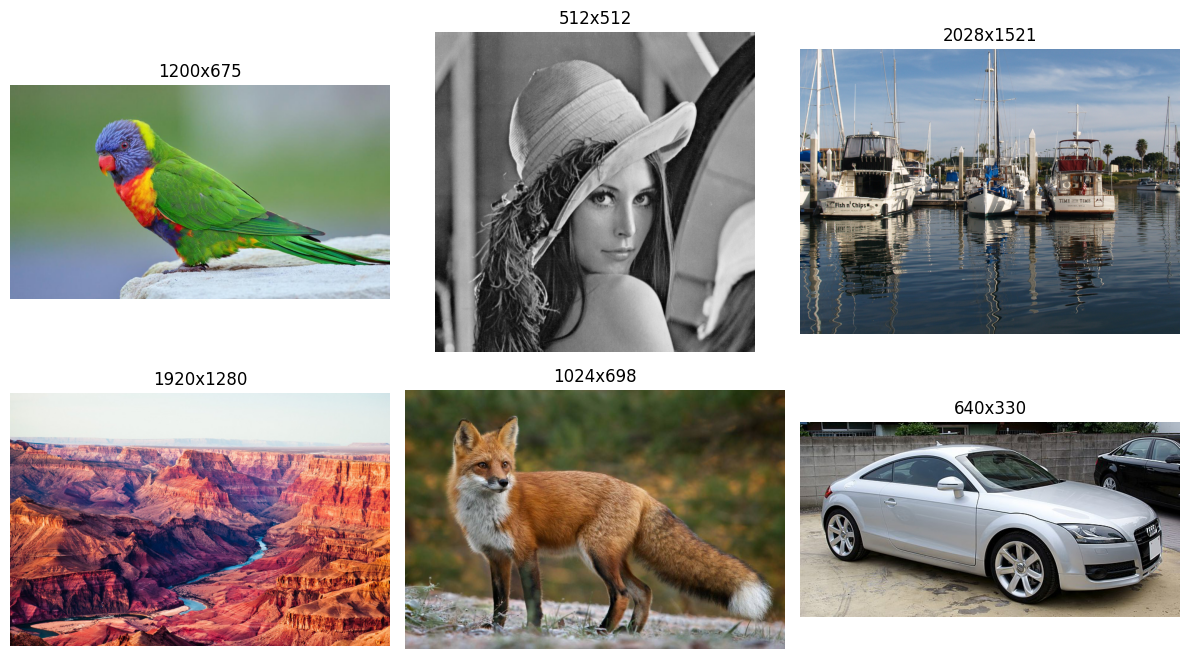

In [74]:
parrot_img = np.array(Image.open("parrot.png"))
lenna_img = np.array(Image.open("lenna.png"))
boats_img = np.array(Image.open("boats.png"))
canyon_img = np.array(Image.open("canyon.jpg"))
fox_img = np.array(Image.open("fox.jpg"))
car_img = np.array(Image.open("car.jpg"))

image_list = [
    (parrot_img, "Parrot"),
    (lenna_img, "Lenna"),
    (boats_img, "Boats"),
    (canyon_img, "Canyon"),
    (fox_img, "Fox"),
    (car_img, "Car")
]

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
axs = axs.ravel()

for img_info, ax in zip(image_list, axs):
    img = img_info[0]
    h, w = img.shape[:2]
    if img_info[1] == "Lenna":
        ax.imshow(img, 'gray')
    else:
        ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{w}x{h}")

plt.tight_layout()
plt.savefig("collage.png", dpi=300)

In [75]:
parrot_img = np.array(Image.open("parrot.png").convert("L"))
lenna_img = np.array(Image.open("lenna.png").convert("L"))
boats_img = np.array(Image.open("boats.png").convert("L"))
canyon_img = np.array(Image.open("canyon.jpg").convert("L"))
fox_img = np.array(Image.open("fox.jpg").convert("L"))
car_img = np.array(Image.open("car.jpg").convert("L"))

image_list = [
    (parrot_img, "Parrot"),
    (lenna_img, "Lenna"),
    (boats_img, "Boats"),
    (canyon_img, "Canyon"),
    (fox_img, "Fox"),
    (car_img, "Car")
]

In [84]:
from matplotlib.patches import Rectangle

def plot_mosaic(method, original, downscaled_ours, upscaled_ours, downscaled_cv2, upscaled_cv2):
    fig = plt.figure(figsize=(12, 12))
    axd = fig.subplot_mosaic(
        """
        .aa.
        bbcc
        ddee
        """,
        # set the height ratios between the rows
        # height_ratios=[2, 2, 2],
        # # set the width ratios between the columns
        # width_ratios=[2, 3, 2],
    )

    fig.suptitle(method, x=0.51, y=0.65, color='purple', size='x-large')
    rect = Rectangle((0.01, 0.01), 0.99, 0.645, facecolor=None, edgecolor='black',
                 transform=fig.transFigure, zorder=-1)
    fig.patches.append(rect)

    ih, iw = original.shape[:2]
    axd['a'].imshow(original, 'gray')
    axd['a'].set_title(f"Original {iw}x{ih}")

    ih, iw = downscaled_ours.shape[:2]
    axd['b'].imshow(downscaled_ours, 'gray')
    axd['b'].set_title(f"Downscaled {iw}x{ih} (ours)")

    ih, iw = upscaled_ours.shape[:2]
    axd['c'].imshow(upscaled_ours, 'gray')
    axd['c'].set_title(f"Upscaled {iw}x{ih}  (ours)")

    ih, iw = downscaled_cv2.shape[:2]
    axd['d'].imshow(downscaled_cv2, 'gray')
    axd['d'].set_title(f"Downscaled {iw}x{ih}  (cv2)")

    ih, iw = upscaled_cv2.shape[:2]
    axd['e'].imshow(upscaled_cv2, 'gray')
    axd['e'].set_title(f"Upscaled {iw}x{ih}  (cv2)")

    plt.tight_layout()

## Parrot

### Nearest

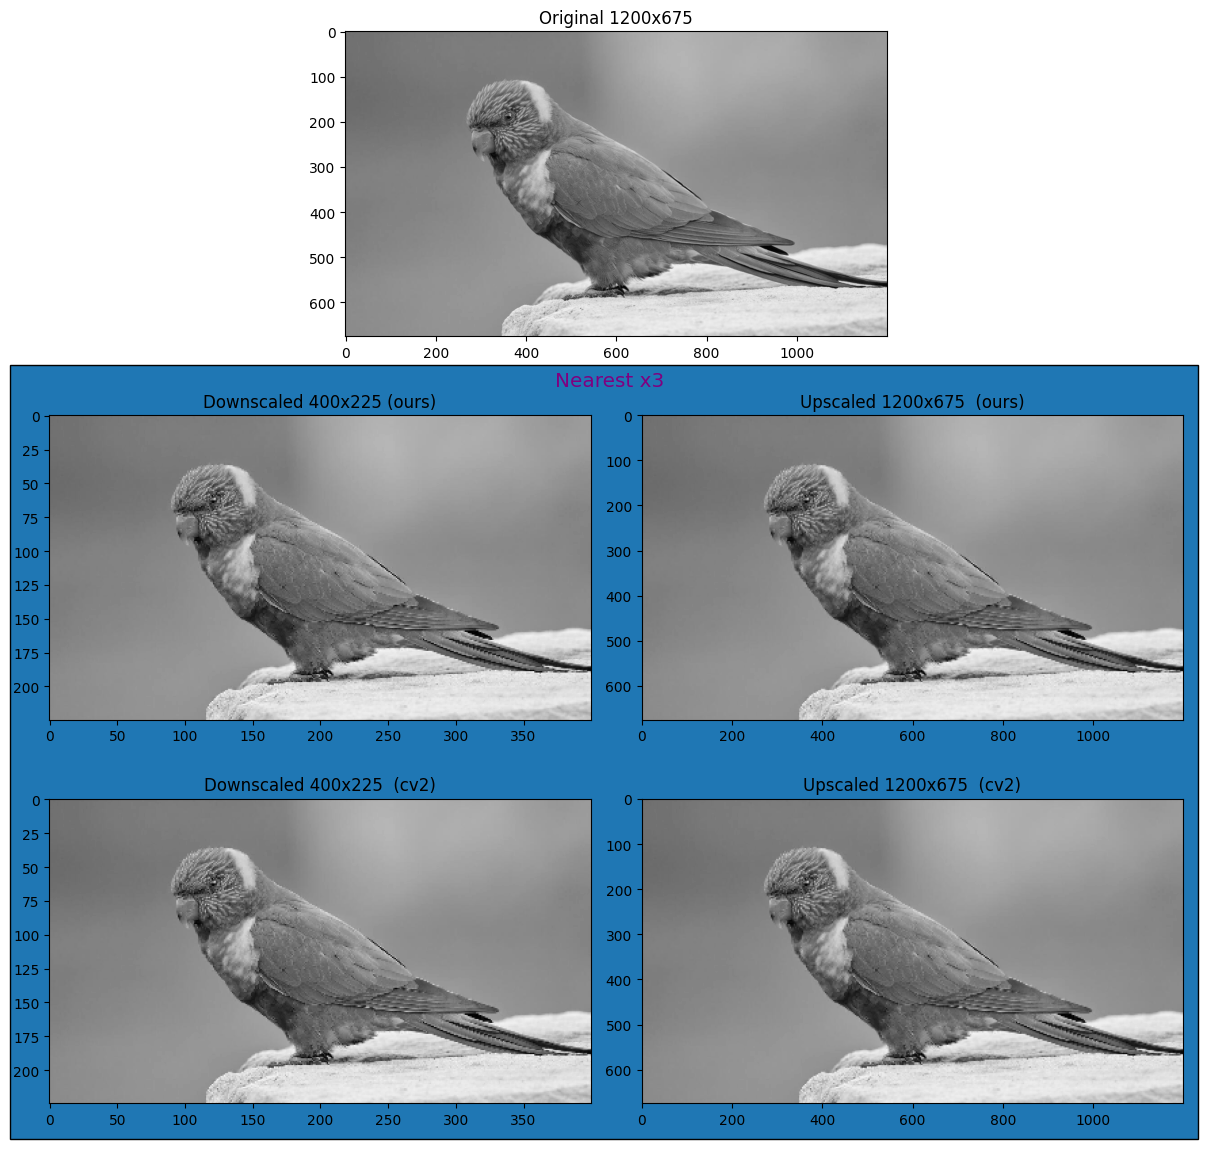

In [98]:
original = parrot_img
scale = 3
original_size = original.shape[:2]
downscale_size = (int(original_size[0] / scale), int(original_size[1] / scale))
nearest_downscale_ours = our_nearest_resize(original, downscale_size)
nearest_upscale_ours = our_nearest_resize(nearest_downscale_ours, original_size)
nearest_downscale_cv2 = wrap_cv2_resize(original, downscale_size, cv2.INTER_NEAREST)
nearest_upscale_cv2 = wrap_cv2_resize(nearest_downscale_cv2, original_size, cv2.INTER_NEAREST)

plot_mosaic(
    f"Nearest x{scale}",
    original=original,
    downscaled_ours=nearest_downscale_ours,
    upscaled_ours=nearest_upscale_ours,
    downscaled_cv2=nearest_downscale_cv2,
    upscaled_cv2=nearest_upscale_cv2,
)

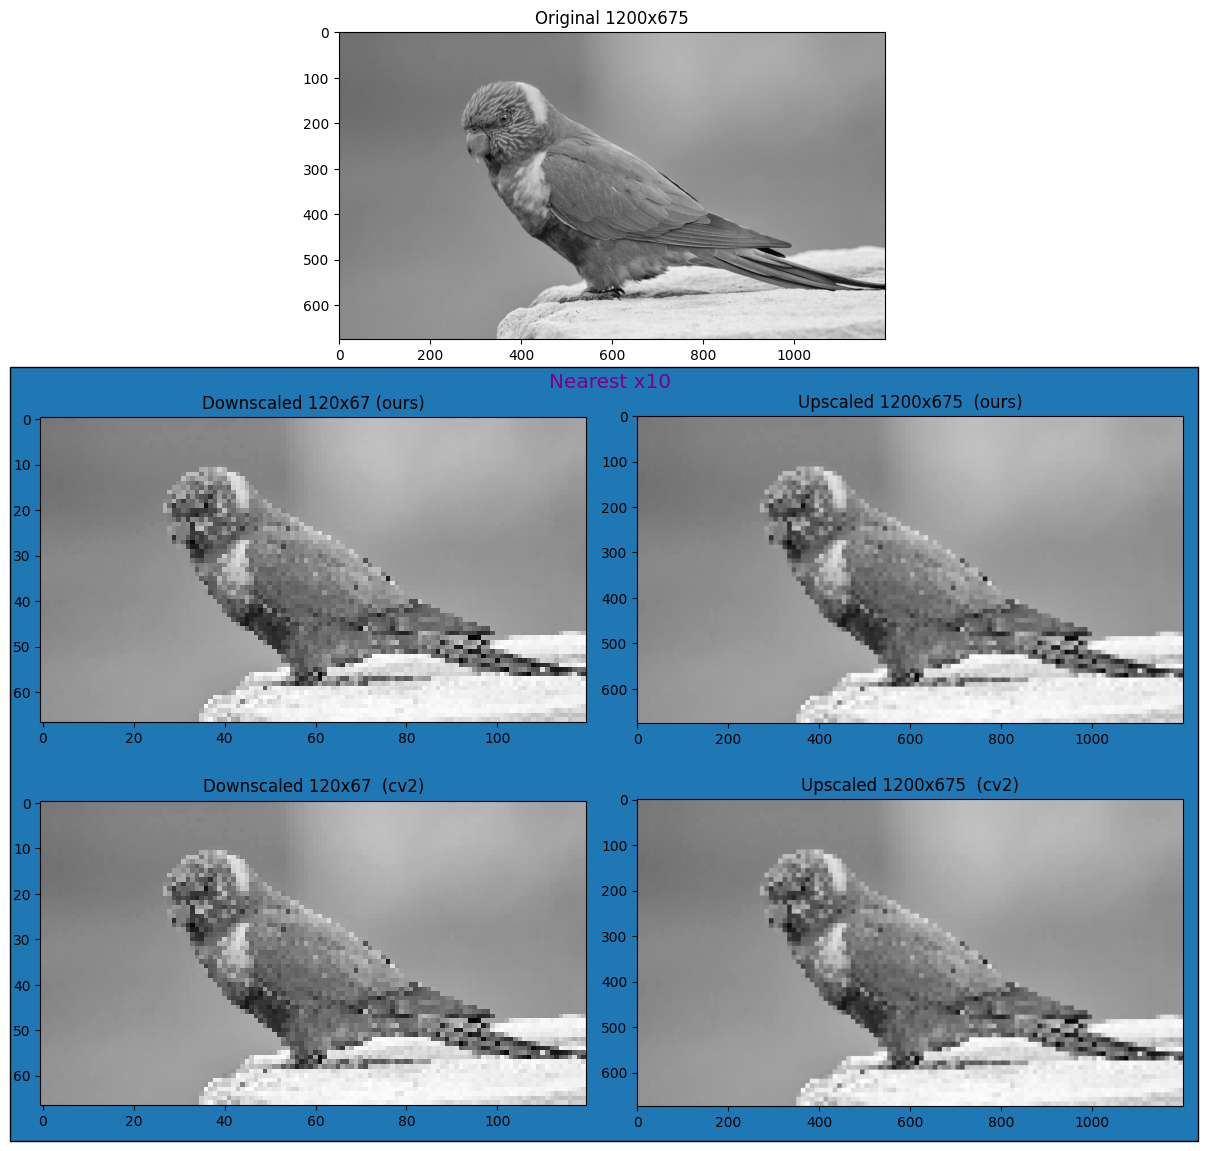

In [99]:
original = parrot_img
scale = 10
original_size = original.shape[:2]
downscale_size = (int(original_size[0] / scale), int(original_size[1] / scale))
nearest_downscale_ours = our_nearest_resize(original, downscale_size)
nearest_upscale_ours = our_nearest_resize(nearest_downscale_ours, original_size)
nearest_downscale_cv2 = wrap_cv2_resize(original, downscale_size, cv2.INTER_NEAREST)
nearest_upscale_cv2 = wrap_cv2_resize(nearest_downscale_cv2, original_size, cv2.INTER_NEAREST)

plot_mosaic(
    f"Nearest x{scale}",
    original=original,
    downscaled_ours=nearest_downscale_ours,
    upscaled_ours=nearest_upscale_ours,
    downscaled_cv2=nearest_downscale_cv2,
    upscaled_cv2=nearest_upscale_cv2,
)

### Bilinear

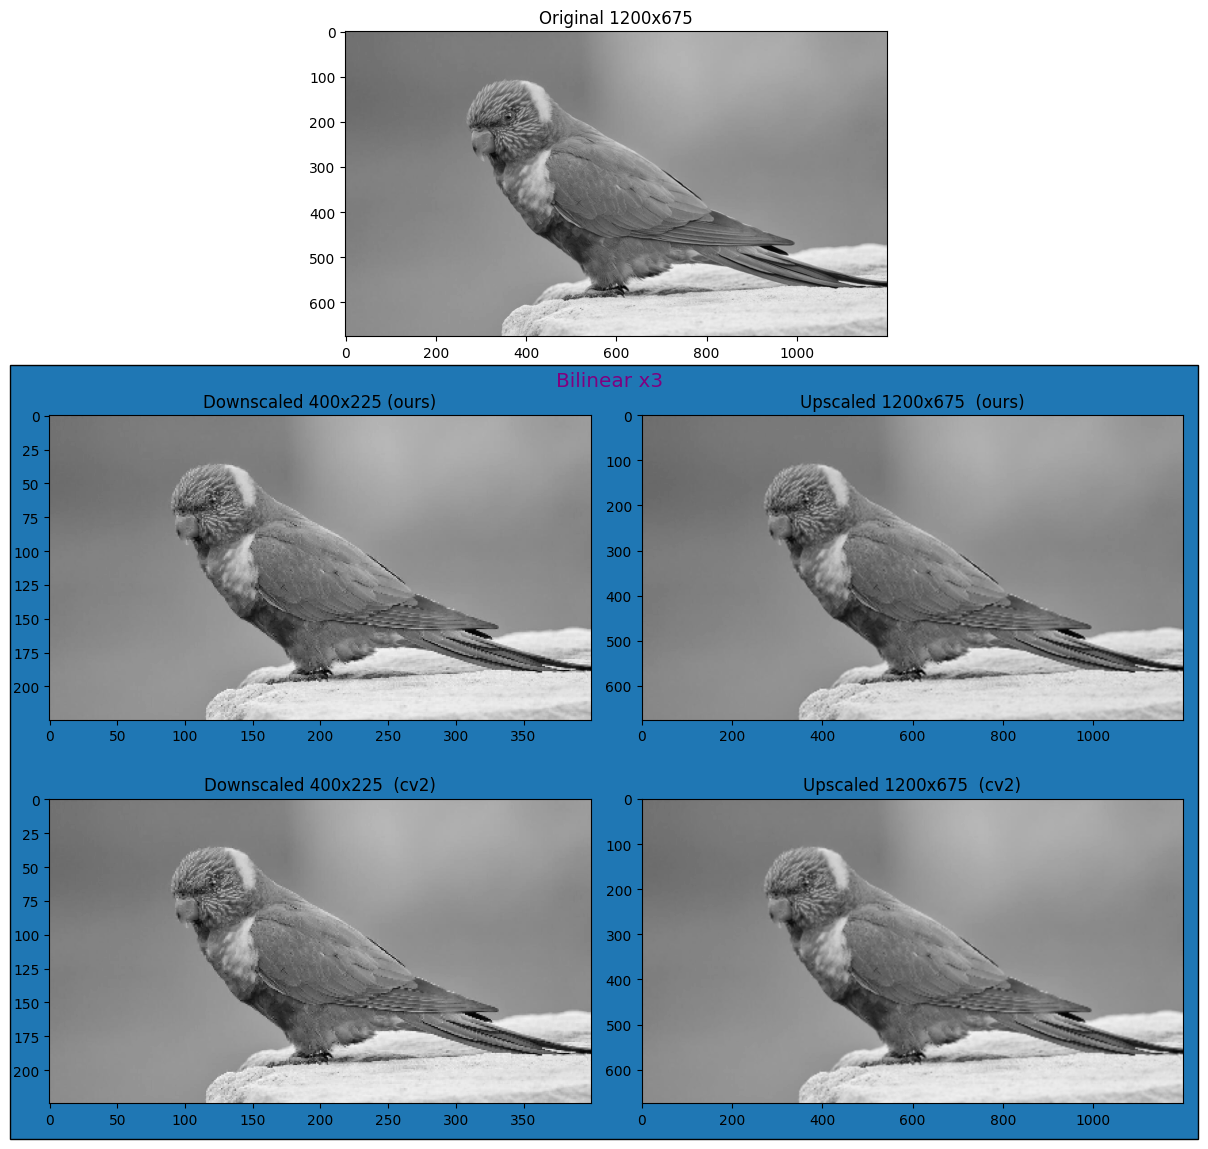

In [100]:
original = parrot_img
scale = 3
original_size = original.shape[:2]
downscale_size = (int(original_size[0] / scale), int(original_size[1] / scale))
bilinear_downscale_ours = our_bilinear_resize(original, downscale_size)
bilinear_upscale_ours = our_bilinear_resize(bilinear_downscale_ours, original_size)
bilinear_downscale_cv2 = wrap_cv2_resize(original, downscale_size, cv2.INTER_LINEAR)
bilinear_upscale_cv2 = wrap_cv2_resize(bilinear_downscale_cv2, original_size, cv2.INTER_LINEAR)

plot_mosaic(
    f"Bilinear x{scale}",
    original=original,
    downscaled_ours=bilinear_downscale_ours,
    upscaled_ours=bilinear_upscale_ours,
    downscaled_cv2=bilinear_downscale_cv2,
    upscaled_cv2=bilinear_upscale_cv2
)

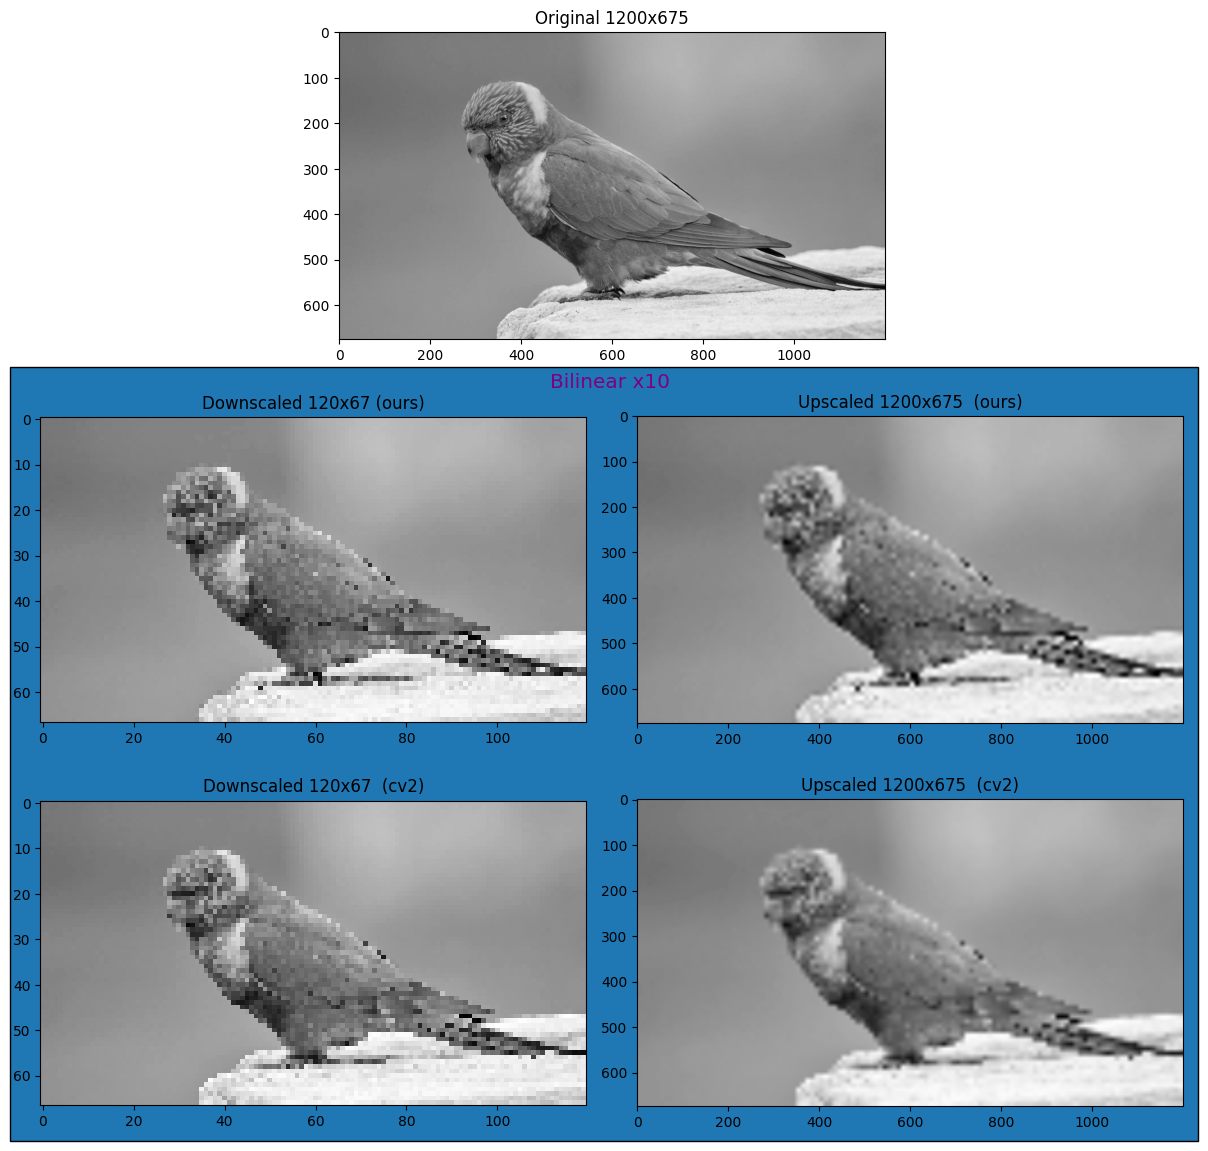

In [101]:
original = parrot_img
scale = 10
original_size = original.shape[:2]
downscale_size = (int(original_size[0] / scale), int(original_size[1] / scale))
bilinear_downscale_ours = our_bilinear_resize(original, downscale_size)
bilinear_upscale_ours = our_bilinear_resize(bilinear_downscale_ours, original_size)
bilinear_downscale_cv2 = wrap_cv2_resize(original, downscale_size, cv2.INTER_LINEAR)
bilinear_upscale_cv2 = wrap_cv2_resize(bilinear_downscale_cv2, original_size, cv2.INTER_LINEAR)

plot_mosaic(
    f"Bilinear x{scale}",
    original=original,
    downscaled_ours=bilinear_downscale_ours,
    upscaled_ours=bilinear_upscale_ours,
    downscaled_cv2=bilinear_downscale_cv2,
    upscaled_cv2=bilinear_upscale_cv2
)

### Bicubic

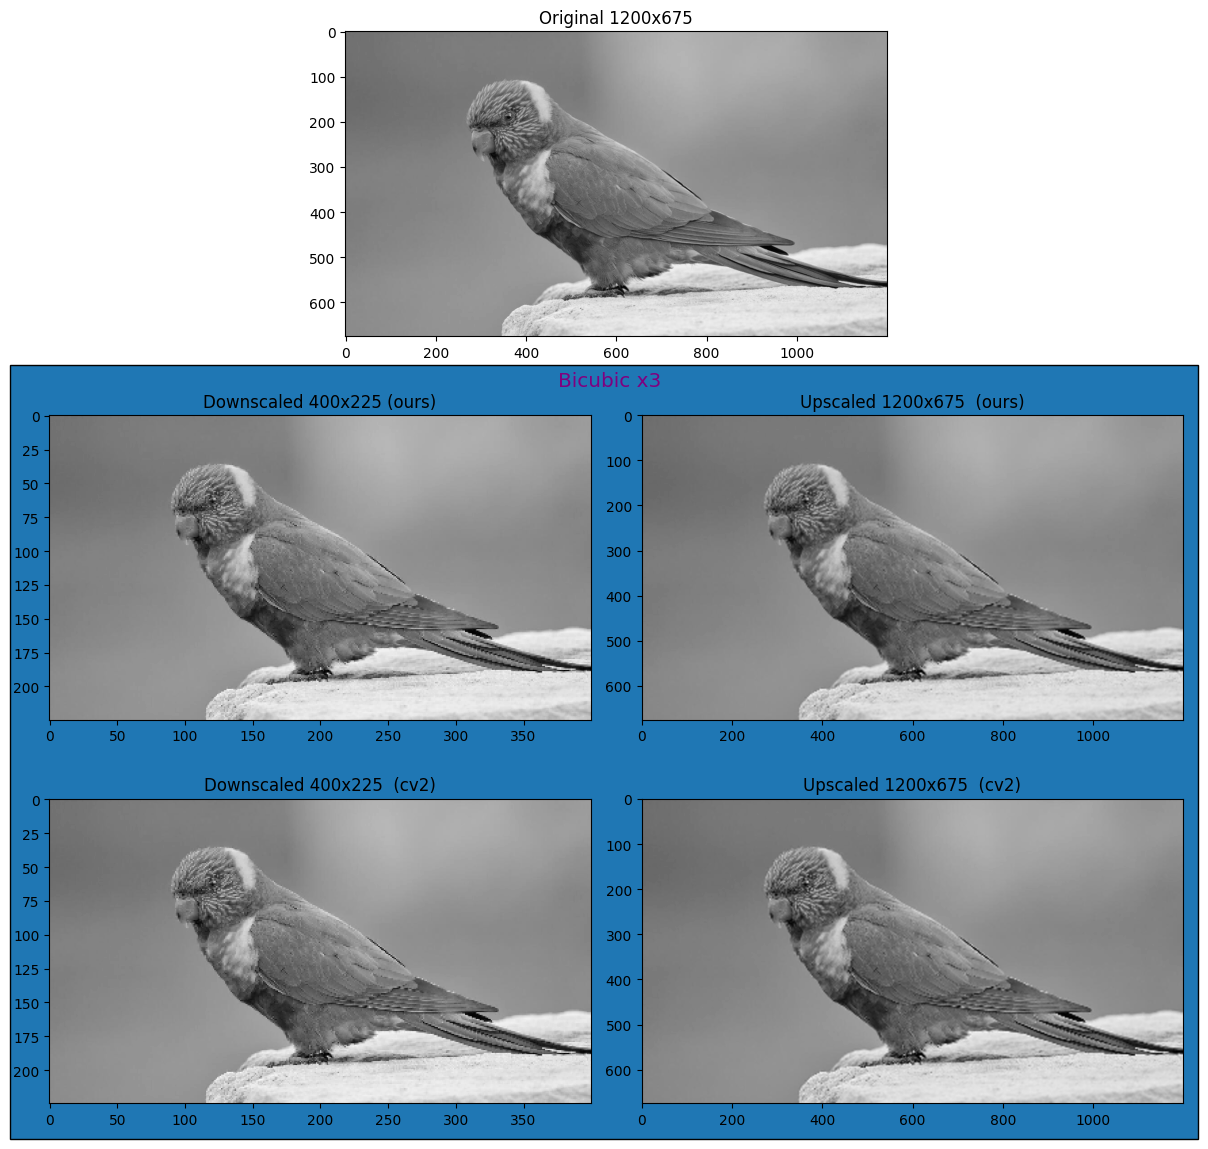

In [102]:
original = parrot_img
scale = 3
original_size = original.shape[:2]
downscale_size = (int(original_size[0] / scale), int(original_size[1] / scale))
bicubic_downscale_ours = out_bicubic_resize(original, downscale_size)
bicubic_upscale_ours = out_bicubic_resize(bicubic_downscale_ours, original_size)
bicubic_downscale_cv2 = wrap_cv2_resize(original, downscale_size, cv2.INTER_CUBIC)
bicubic_upscale_cv2 = wrap_cv2_resize(bicubic_downscale_cv2, original_size, cv2.INTER_CUBIC)

plot_mosaic(
    f"Bicubic x{scale}",
    original=original,
    downscaled_ours=bicubic_downscale_ours,
    upscaled_ours=bicubic_upscale_ours,
    downscaled_cv2=bicubic_downscale_cv2,
    upscaled_cv2=bicubic_upscale_cv2
)

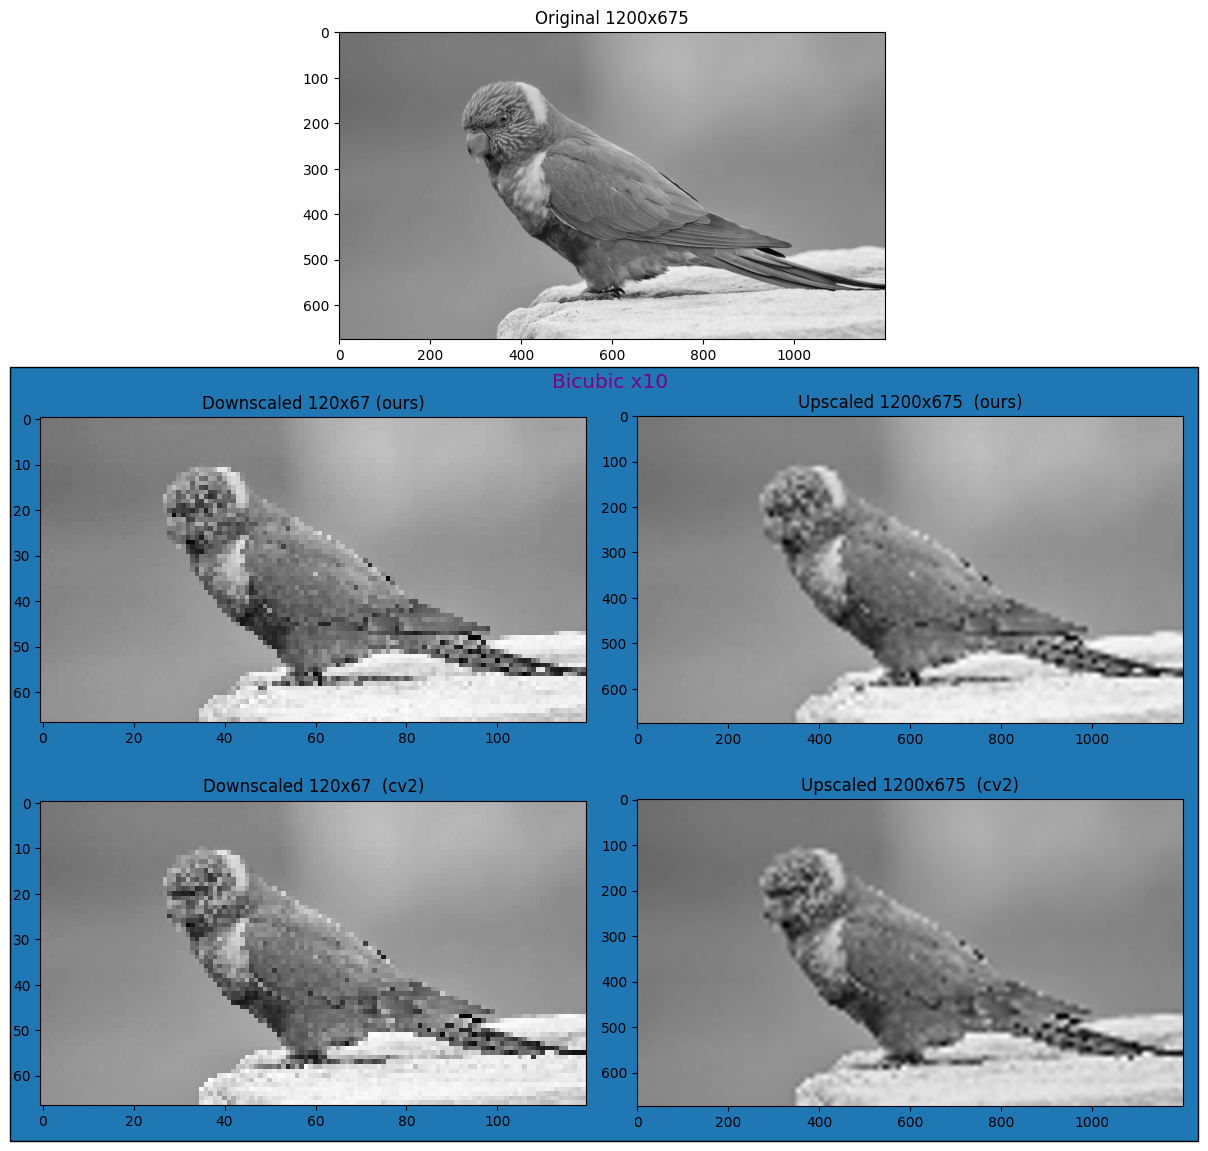

In [103]:
original = parrot_img
scale = 10
original_size = original.shape[:2]
downscale_size = (int(original_size[0] / scale), int(original_size[1] / scale))
bicubic_downscale_ours = out_bicubic_resize(original, downscale_size)
bicubic_upscale_ours = out_bicubic_resize(bicubic_downscale_ours, original_size)
bicubic_downscale_cv2 = wrap_cv2_resize(original, downscale_size, cv2.INTER_CUBIC)
bicubic_upscale_cv2 = wrap_cv2_resize(bicubic_downscale_cv2, original_size, cv2.INTER_CUBIC)

plot_mosaic(
    f"Bicubic x{scale}",
    original=original,
    downscaled_ours=bicubic_downscale_ours,
    upscaled_ours=bicubic_upscale_ours,
    downscaled_cv2=bicubic_downscale_cv2,
    upscaled_cv2=bicubic_upscale_cv2
)

## MSE & SSIM

In [104]:
def get_metrics(method, downscale_factors):
    parrot_img = np.array(Image.open("parrot.png").convert("L"))
    lenna_img = np.array(Image.open("lenna.png").convert("L"))
    boats_img = np.array(Image.open("boats.png").convert("L"))
    canyon_img = np.array(Image.open("canyon.jpg").convert("L"))
    fox_img = np.array(Image.open("fox.jpg").convert("L"))
    car_img = np.array(Image.open("car.jpg").convert("L"))

    image_list = [
        (parrot_img, "Parrot"),
        (lenna_img, "Lenna"),
        (boats_img, "Boats"),
        (canyon_img, "Canyon"),
        (fox_img, "Fox"),
        (car_img, "Car")
    ]
    ssim_by_image = {
        item[1]: [] for item in image_list
    }
    mse_by_image = {
        item[1]: [] for item in image_list
    }

    for downscale_factor in downscale_factors:
        for img_name in image_list:
            img, name = img_name
            ih, iw = img.shape[:2]
            downscale_size = (ih // downscale_factor, iw // downscale_factor)
            downscale_size = tuple(map(int, downscale_size))
            downscaled, upscaled = downscale_and_upscale(img, downscale_size, method)
            mse_val = mse(img, upscaled)
            ssim_val = ssim(img, upscaled)
            ssim_by_image[name].append(ssim_val)
            mse_by_image[name].append(mse_val)

    return ssim_by_image, mse_by_image

def plot_metrics(method, ssim_by_image, mse_by_image, downscale_factors):
    scales = [f"scale {scale}" for scale in downscale_factors]
    x = np.arange(0, len(scales)*6, 6)  # the label locations
    width = 0.9 # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(13, 8), ncols=2, sharey=True)
    ax = ax.ravel()
    fig.suptitle(f"               Metrics between Original and Downscaled+Upscaled images ({method[0]})")

    ax[0].set_title("Structural Similarity Index (SSIM)", fontsize=13, pad=15, color="red")
    for name, metrics in ssim_by_image.items():
        offset = width * multiplier
        rects = ax[0].barh(x + offset, metrics, width, label=name)
        ax[0].bar_label(rects, padding=-25, fmt="%.2f")
        multiplier += 1
    ax[0].set_yticks(x + width*2, scales)
    ax[0].margins(x=0.1)
    ax[0].set_ylim(-1, len(scales)*6)
    ax[0].invert_xaxis() 

    ax[1].set_title("Mean Squared Error (MSE)", fontsize=13, pad=15, color="red")
    multiplier = 0
    for name, metrics in mse_by_image.items():
        offset = width * multiplier
        rects = ax[1].barh(x + offset, metrics, width, label="\n"+name+"\n")
        ax[1].bar_label(rects, padding=3, fmt="%.1f")
        multiplier += 1
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles[::-1], labels[::-1], loc='lower right', prop={'size': 10})
    ax[1].set_ylim(-1, len(scales)*6)
    ax[1].margins(x=0.45)

    plt.show()


def get_mean_by_scale(dct, downscale_factors):
    mean = {scale: [] for scale in downscale_factors}
    for i, scale in enumerate(downscale_factors):
        for metrics in dct.values():
            mean[scale].append(metrics[i])
    
    return {k: np.mean(v) for k, v in mean.items()}


def plot_mean_metrics(method_order, ssim_m1, ssim_m2, mse_m1, mse_m2, downscale_factors):
    ssim_mean_by_scale_m1 = get_mean_by_scale(ssim_m1, downscale_factors)
    ssim_mean_by_scale_m2 = get_mean_by_scale(ssim_m2, downscale_factors)
    ssim_mean = {method_order[0]: list(ssim_mean_by_scale_m1.values()), method_order[1]: list(ssim_mean_by_scale_m2.values())}

    mse_mean_by_scale_m1 = get_mean_by_scale(mse_m1, downscale_factors)
    mse_mean_by_scale_m2 = get_mean_by_scale(mse_m2, downscale_factors)
    mse_mean = {method_order[0]: list(mse_mean_by_scale_m1.values()), method_order[1]: list(mse_mean_by_scale_m2.values())}
   
    scales = [f"scale {scale}" for scale in downscale_factors]
    x = np.arange(len(scales))  # the label locations
    width = 0.4 # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(13, 8), ncols=2, sharey=True)
    ax = ax.ravel()
    fig.suptitle(f"               Averaged metrics ({method_order[0]} vs {method_order[1]})")
    colors = ["purple", "orange"]
    ax[0].set_title("Structural Similarity Index (SSIM)", fontsize=13, pad=15, color="red")
    for i, (method, metrics) in enumerate(ssim_mean.items()):
        offset = width * multiplier
        rects = ax[0].barh(x + offset, metrics, width, label=method, color=colors[i])
        ax[0].bar_label(rects, padding=-25, fmt="%.2f")
        multiplier += 1
    ax[0].set_yticks(x + width / 2, scales)
    ax[0].margins(x=0.1)
    # ax[0].set_ylim(-1, len(scales)*6)
    ax[0].invert_xaxis() 

    ax[1].set_title("Mean Squared Error (MSE)", fontsize=13, pad=15, color="red")
    multiplier = 0
    for i, (method, metrics) in enumerate(mse_mean.items()):
        offset = width * multiplier
        rects = ax[1].barh(x + offset, metrics, width, label="\n"+method+"\n", color=colors[i])
        ax[1].bar_label(rects, padding=3, fmt="%.1f")
        multiplier += 1
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend(handles[::-1], labels[::-1], loc='lower right', prop={'size': 10})
    # ax[1].set_ylim(-1, len(scales)*6)
    ax[1].margins(x=0.45)

    plt.show()

## Nearest

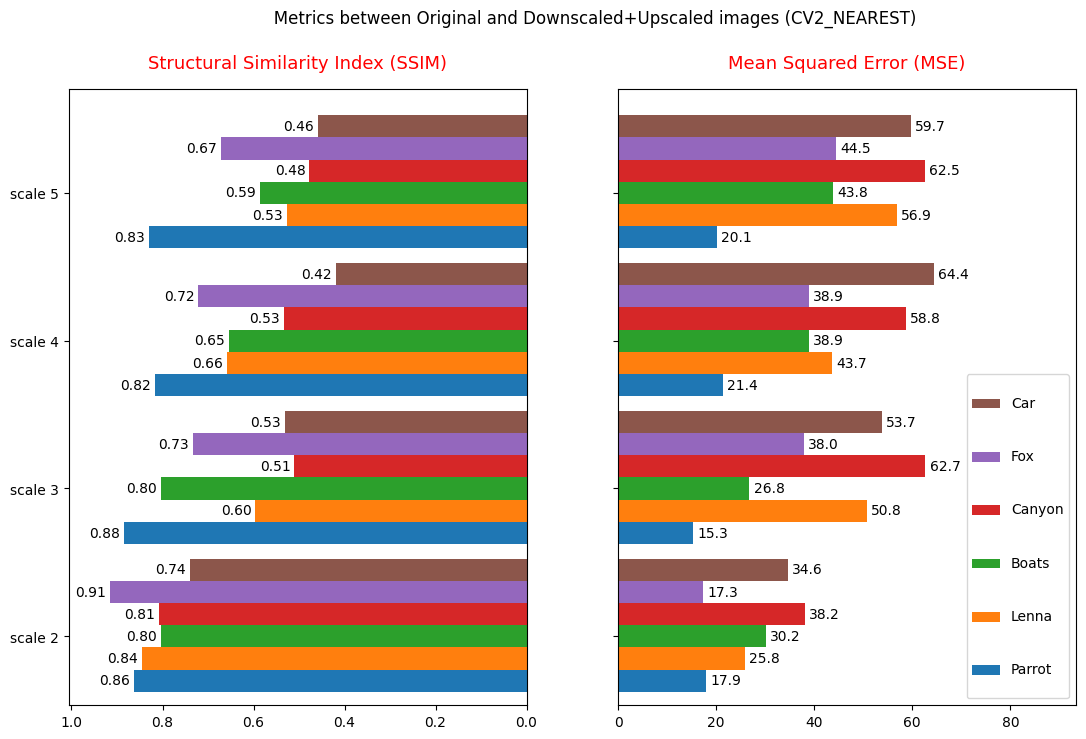

In [114]:
ssim_by_image_cv2, mse_by_image_cv2 = get_metrics(["CV2_NEAREST", cv2.INTER_NEAREST], [2, 3, 4, 5])
plot_metrics(["CV2_NEAREST", cv2.INTER_NEAREST], ssim_by_image_cv2, mse_by_image_cv2, [2, 3, 4, 5])

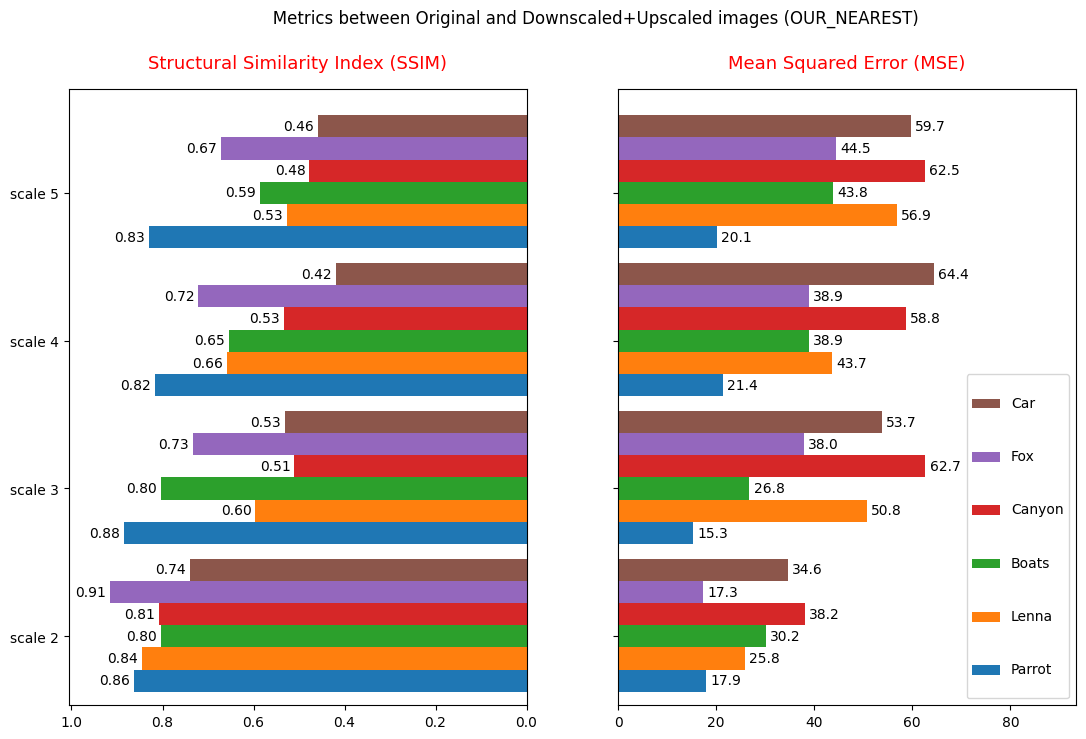

In [115]:
ssim_by_image_ours, mse_by_image_ours = get_metrics(["OUR_NEAREST", our_nearest_resize], [2, 3, 4, 5])
plot_metrics(["OUR_NEAREST", our_nearest_resize], ssim_by_image_ours, mse_by_image_ours, [2, 3, 4, 5])

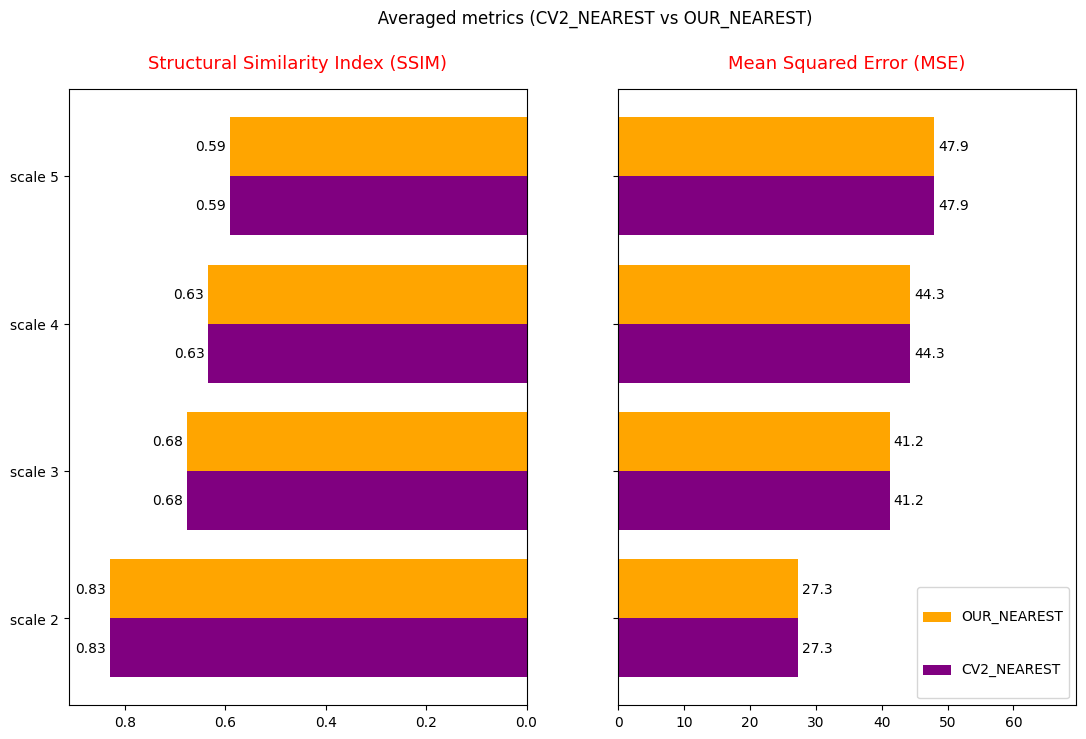

In [116]:
plot_mean_metrics(["CV2_NEAREST", "OUR_NEAREST"], ssim_by_image_cv2, ssim_by_image_ours, mse_by_image_cv2, mse_by_image_ours, [2, 3, 4, 5])

## Bilinear

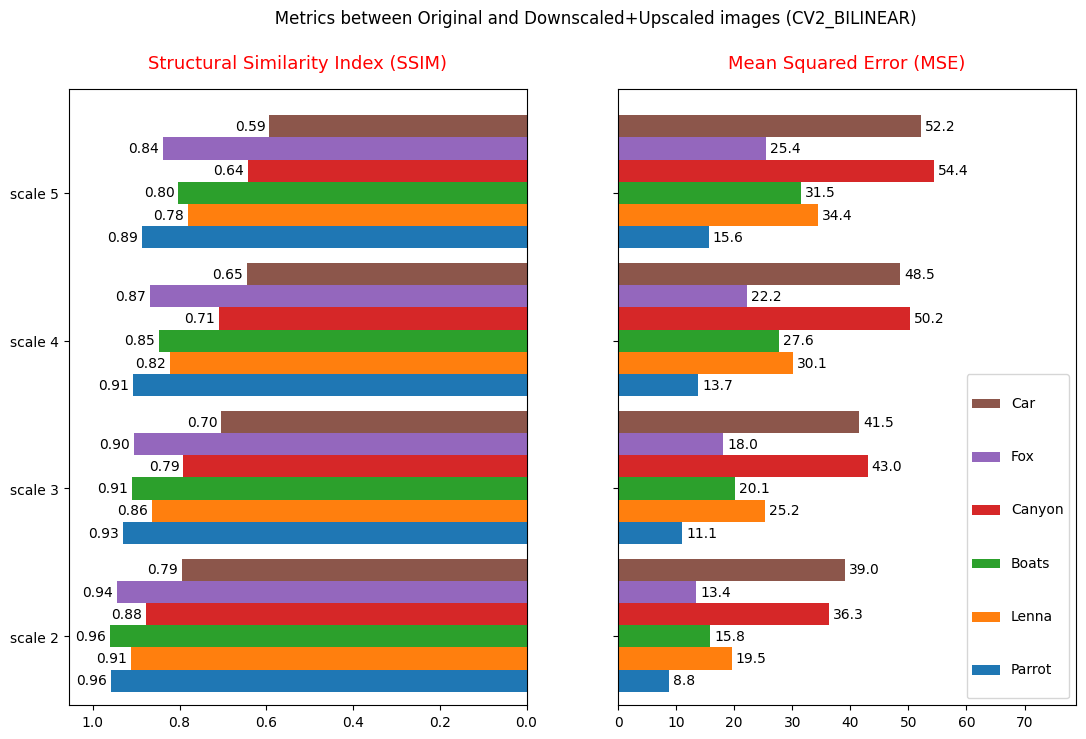

In [105]:
ssim_by_image_cv2, mse_by_image_cv2 = get_metrics(["CV2_BILINEAR", cv2.INTER_LINEAR], [2, 3, 4, 5])
plot_metrics(["CV2_BILINEAR", cv2.INTER_LINEAR], ssim_by_image_cv2, mse_by_image_cv2, [2, 3, 4, 5])

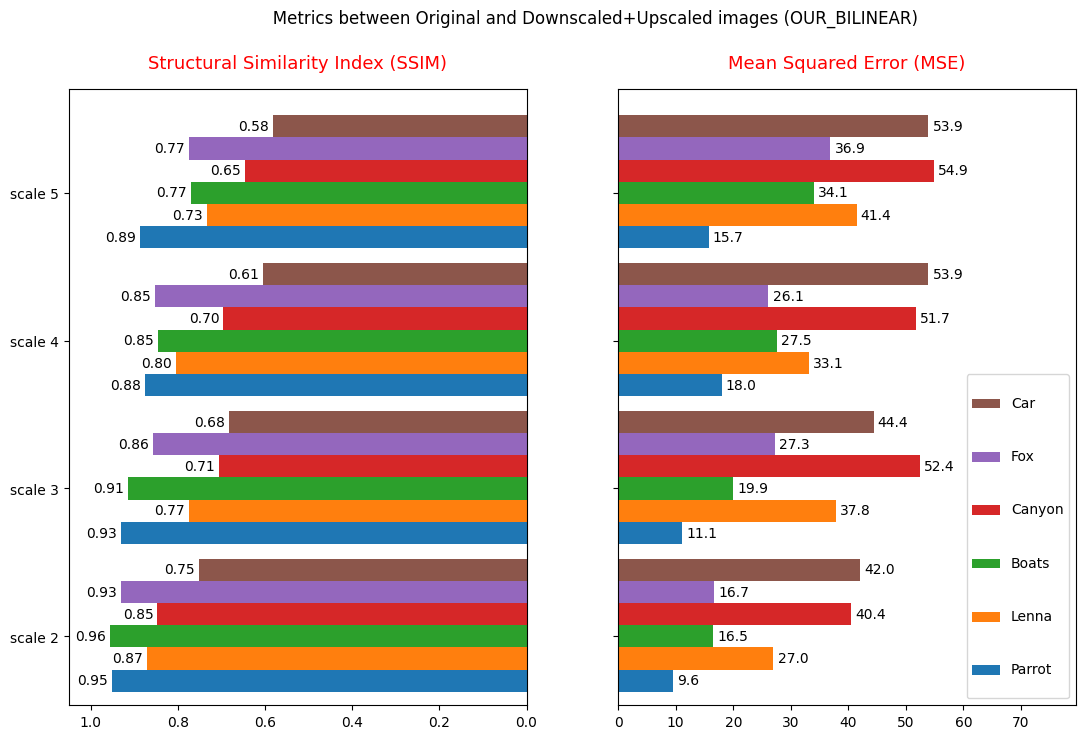

In [106]:
ssim_by_image_ours, mse_by_image_ours = get_metrics(["OUR_BILINEAR", our_bilinear_resize], [2, 3, 4, 5])
plot_metrics(["OUR_BILINEAR", our_bilinear_resize], ssim_by_image_ours, mse_by_image_ours, [2, 3, 4, 5])

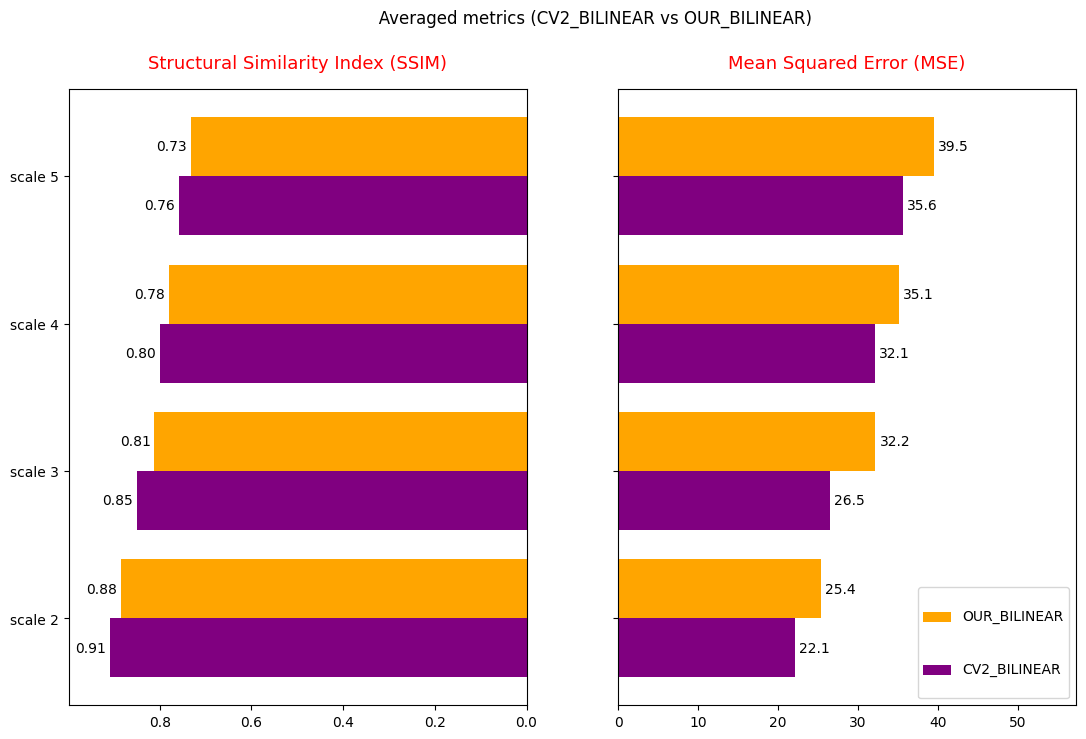

In [107]:
plot_mean_metrics(["CV2_BILINEAR", "OUR_BILINEAR"], ssim_by_image_cv2, ssim_by_image_ours, mse_by_image_cv2, mse_by_image_ours, [2, 3, 4, 5])

## Bicubic

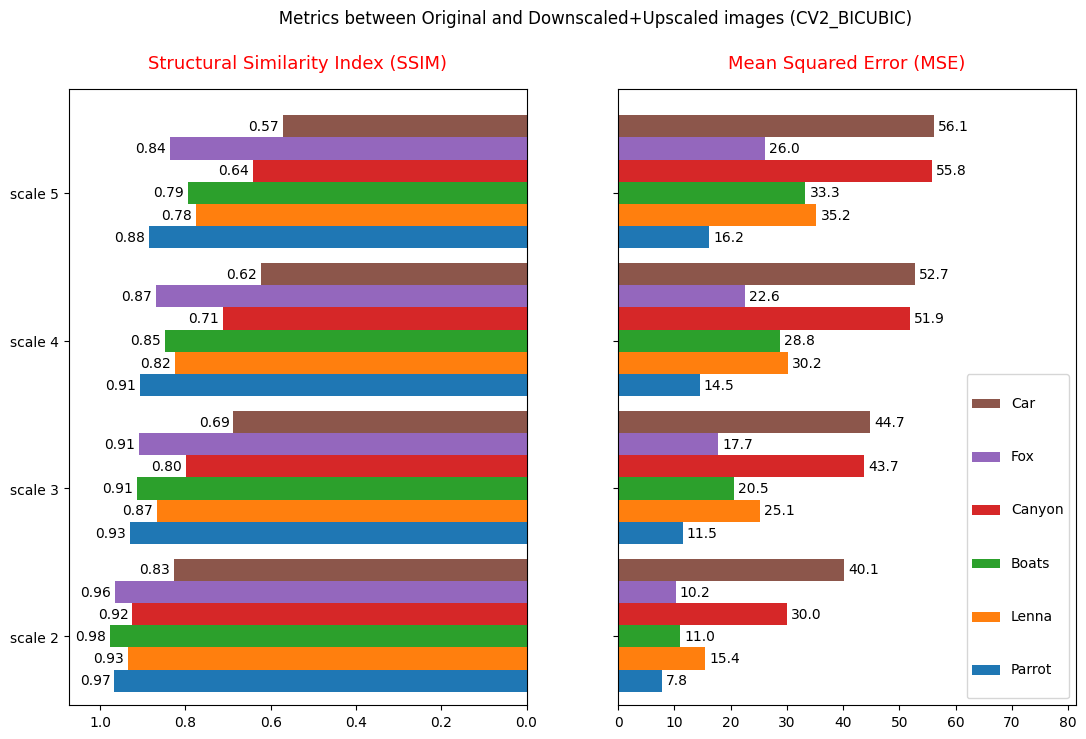

In [111]:
ssim_by_image_cv2, mse_by_image_cv2 = get_metrics(["CV2_BICUBIC", cv2.INTER_CUBIC], [2, 3, 4, 5])
plot_metrics(["CV2_BICUBIC", cv2.INTER_CUBIC], ssim_by_image_cv2, mse_by_image_cv2, [2, 3, 4, 5])

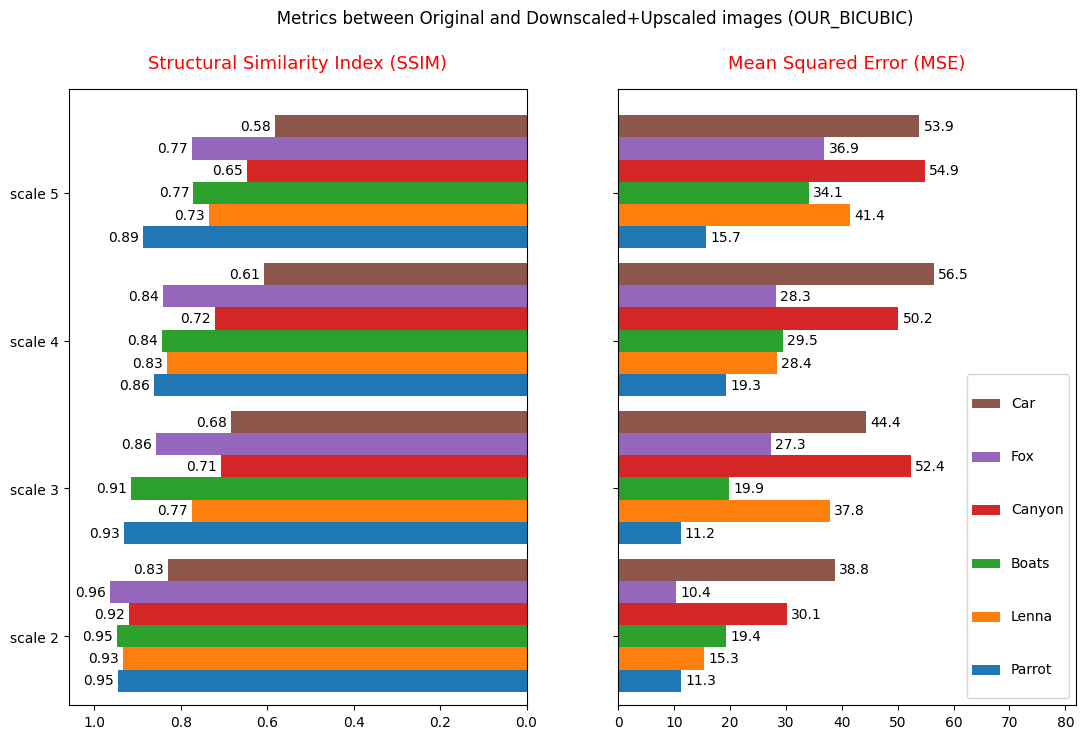

In [112]:
ssim_by_image_ours, mse_by_image_ours = get_metrics(["OUR_BICUBIC", out_bicubic_resize], [2, 3, 4, 5])
plot_metrics(["OUR_BICUBIC", out_bicubic_resize], ssim_by_image_ours, mse_by_image_ours, [2, 3, 4, 5])

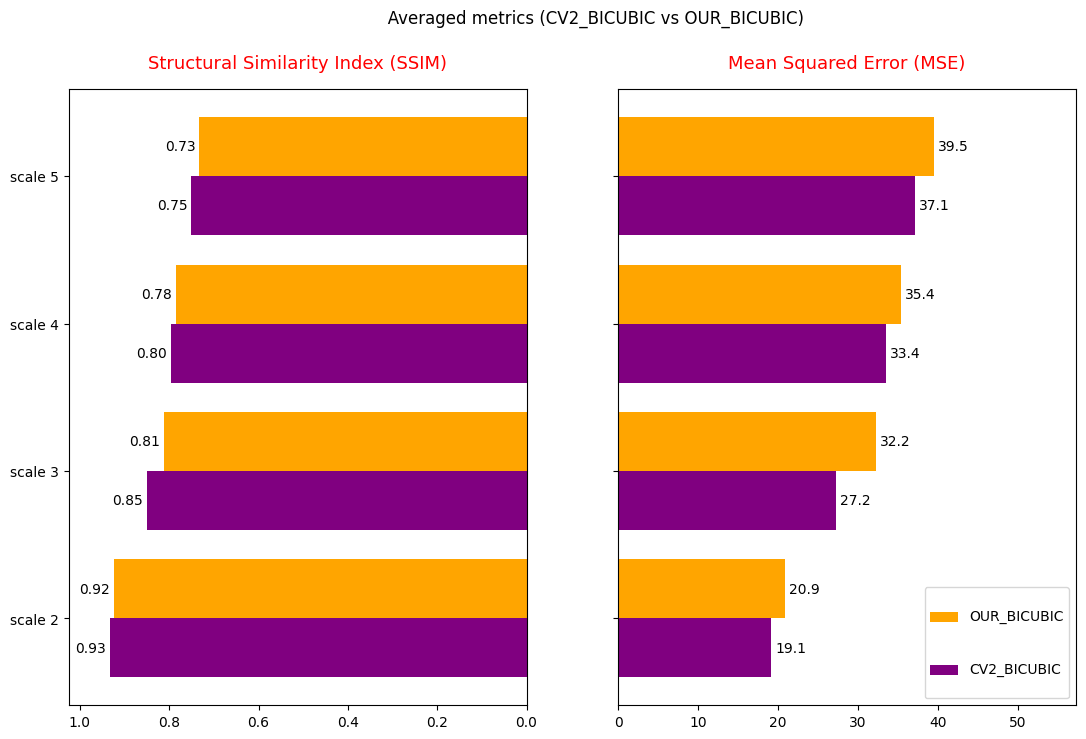

In [113]:
plot_mean_metrics(["CV2_BICUBIC", "OUR_BICUBIC"], ssim_by_image_cv2, ssim_by_image_ours, mse_by_image_cv2, mse_by_image_ours, [2, 3, 4, 5])